In [51]:
import numpy as np
from numpy import cos, sin
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


# calibration

## We calibrate our sensors with Six-Position Direct Method

In [52]:
fields = ['ax','ay','az','gx','gy','gz','time','date']
Xdn = pd.read_csv(r'data\calibration\X\1.csv', skiprows=1, names=fields)
Xup = pd.read_csv(r'data\calibration\X\2.csv', skiprows=1, names=fields)

Ydn = pd.read_csv(r'data\calibration\Y\1.csv', skiprows=1, names=fields)
Yup = pd.read_csv(r'data\calibration\Y\2.csv', skiprows=1, names=fields)

Zdn = pd.read_csv(r'data\calibration\Z\1.csv', skiprows=1, names=fields)
Zup = pd.read_csv(r'data\calibration\Z\2.csv', skiprows=1, names=fields)

### Bias error

In [53]:
bXa = (Xdn.iloc[:,0].mean()+Xup.iloc[:,0].mean())/2
bYa = (Ydn.iloc[:,1].mean()+Yup.iloc[:,1].mean())/2
bZa = (Zdn.iloc[:,2].mean()+Zup.iloc[:,2].mean())/2

bXg = (Xdn.iloc[:,3].mean()+Xup.iloc[:,3].mean())/2
bYg = (Ydn.iloc[:,4].mean()+Yup.iloc[:,4].mean())/2
bZg = (Zdn.iloc[:,5].mean()+Zup.iloc[:,5].mean())/2

ba = np.array([bXa,bYa,bZa])
bg = np.array([bXg,bYg,bZg])
print('ba = ',ba)
print('bg = ',bg)

ba =  [ 0.04502027 -0.00757121 -0.07367044]
bg =  [ 1.01035472e-04 -2.94080378e-05  5.76577331e-07]


### Scale error

In [54]:
# from google map
lat_0 = np.deg2rad(32.780724)
lon_0 = np.deg2rad(35.020606)
h_0 = 183
g = 9.7803 + 0.051799*sin(lat_0) - h_0*0.94114/1000000

In [55]:
sXa = (np.abs(Xdn.iloc[:,0].mean()-Xup.iloc[:,0].mean())-2*g)/(2*g)
sYa = (np.abs(Ydn.iloc[:,1].mean()-Yup.iloc[:,1].mean())-2*g)/(2*g)
sZa = (np.abs(Zdn.iloc[:,2].mean()-Zup.iloc[:,2].mean())-2*g)/(2*g)

sa = np.array([sXa,sYa,sZa])
print('sa = ',sa)

sa =  [-0.0043213  -0.00250205 -0.0013414 ]


In [56]:
print(Xdn.iloc[:,0].mean())
print(Xup.iloc[:,0].mean())
print(Ydn.iloc[:,1].mean())
print(Yup.iloc[:,1].mean())
print(Zdn.iloc[:,2].mean())
print(Zup.iloc[:,2].mean())

9.810809281627797
-9.720768743914414
-9.791203715992124
9.776061287269464
-9.868686837029713
9.721345964768654


## Load accelerometer and gyro data

In [57]:
# read data
# ins = pd.read_csv(r'data\11Steps_AndroSensor.csv', skiprows=1, names=fields)
# ins = pd.read_csv(r'data\calibration\X\1.csv', skiprows=1, names=fields)
ins = pd.read_csv(r'data\11Steps_AndroSensor.csv', skiprows=1, names=fields)
# ins.columns = ['ax','ay','az','gx','gy','gz','time','date']
ins.head()

,ax,ay,az,gx,gy,gz,time,date
0,-1.025,1.195,10.511,-0.875,-1.391,0.23,40,2021-01-18 09:20:46:496
1,-1.025,1.195,10.511,-0.875,-1.391,0.23,48,2021-01-18 09:20:46:504
2,-1.025,1.195,10.511,-0.875,-1.391,0.23,58,2021-01-18 09:20:46:514
3,-1.025,1.195,10.511,-0.875,-1.391,0.23,68,2021-01-18 09:20:46:524
4,-1.025,1.195,10.511,-0.875,-1.391,0.23,78,2021-01-18 09:20:46:534


## Preproccess

In [58]:
# order column
acc_1 = ins[['time','ax','ay','az']]
gyro_1 = ins[['time','gx','gy','gz']]

gyro_1.head()

,time,gx,gy,gz
0,40,-0.875,-1.391,0.23
1,48,-0.875,-1.391,0.23
2,58,-0.875,-1.391,0.23
3,68,-0.875,-1.391,0.23
4,78,-0.875,-1.391,0.23


In [59]:
# Total acceleration
acc_1['magnitude'] =np.sqrt(acc_1['ax']**2+acc_1['ay']**2+acc_1['az']**2)

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
# Define the first sample as '0' and convert from nanoseconds to seconds
acc_1['time'] = (acc_1['time']-acc_1.loc[0,'time'])*(1e-3)
gyro_1['time'] = (gyro_1['time']-gyro_1.loc[0,'time'])*(1e-3)

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Reduce bias computed in the calibration

In [61]:
acc_1.head()

,time,ax,ay,az,magnitude
0,0.000,-1.025,1.195,10.511,10.628253
1,0.008,-1.025,1.195,10.511,10.628253
2,0.018,-1.025,1.195,10.511,10.628253
3,0.028,-1.025,1.195,10.511,10.628253
4,0.038,-1.025,1.195,10.511,10.628253


In [62]:
# bais
# acc_1.iloc[:,1:4] = (acc_1.iloc[:,1:4]-ba)/(1+sa)
# acc_1['magnitude'] = np.sqrt(acc_1['ax']**2+acc_1['ay']**2+acc_1['az']**2)
# gyro_1.iloc[:,1:4] = gyro_1.iloc[:,1:4]-bg

acc_1.head()

,time,ax,ay,az,magnitude
0,0.000,-1.025,1.195,10.511,10.628253
1,0.008,-1.025,1.195,10.511,10.628253
2,0.018,-1.025,1.195,10.511,10.628253
3,0.028,-1.025,1.195,10.511,10.628253
4,0.038,-1.025,1.195,10.511,10.628253


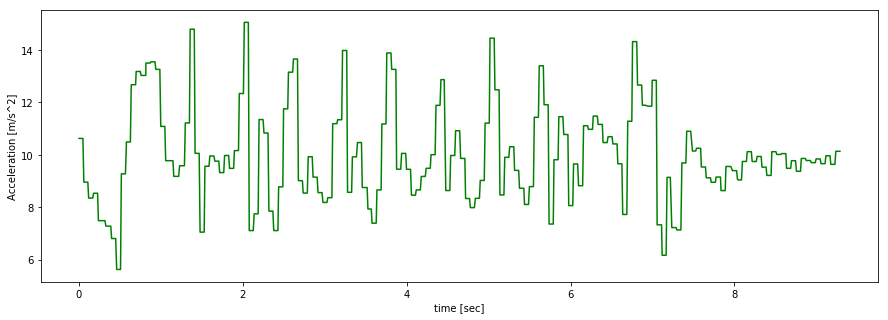

In [63]:
# plot acceleration
fig = plt.figure(figsize=(15,5))
plt.plot(acc_1['time'],acc_1['magnitude'], '-g')
plt.xlabel('time [sec]')
plt.ylabel('Acceleration [m/s^2]')
plt.show()

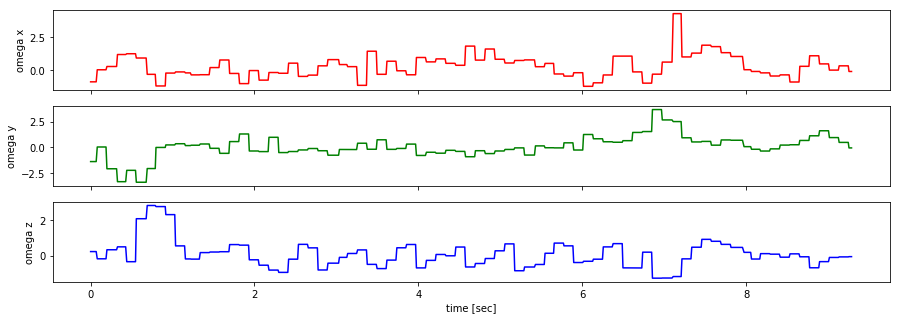

In [64]:
# plot gyroscope data in each axes
fig, axs = plt.subplots(nrows=3, ncols=1,sharex=True, figsize=(15,5))

axs[0].plot(gyro_1['time'],gyro_1['gx'], '-r')
axs[0].set_ylabel('omega x')

axs[1].plot(gyro_1['time'],gyro_1['gy'], '-g')
axs[1].set_ylabel('omega y')

axs[2].plot(gyro_1['time'],gyro_1['gz'], '-b')
axs[2].set_ylabel('omega z')

axs[2].set_xlabel('time [sec]')


plt.show()

# Navigation

In [65]:
def vector2anti_Sim(v):
    return np.array([[0,-v[2],v[1]],[v[2],0,-v[0]],[-v[1],v[0],0]])

## Initial conditions

In [66]:
# Initial parameters
Re = 6378137
e = 0.0818191908
omega_ie = (2*np.pi)/(24*60*60) # Earth turn rate

# Calc' initial angles (10 sec' in stationary conditions
fx = acc_1.loc[:10,'ax'].mean()
fy = acc_1.loc[:10,'ay'].mean()
fz = acc_1.loc[:10,'az'].mean()

roll_0 = np.arctan2(-fy, -fz)
pitch_0 = np.arctan2(-fx, np.sqrt(fz**2 + fy**2))
# from compass
yaw_0 = np.deg2rad(230)

# from google map
lat_0 = np.deg2rad(32.780724)
lon_0 = np.deg2rad(35.020606)
h_0 = 183

v_0 = np.array([[0,0,0]]).T
# r_0 = np.array([[lat_0, lon_0, h_0]]).T
r_0 = np.array([[0, 0, 0]]).T

Rm = Re * (1 - e ** 2) / (1 - e ** 2 * sin(lat_0) * 2) ** (3 / 2)
Rn = Re / (1 - e ** 2 * sin(lat_0) * 2) ** (1 / 2)
g = 9.7803 + 0.051799*sin(lat_0) - h_0*0.94114/1000000
gn = np.array([[0,0,g]]).T


In [67]:
# Rotation matrix
T_yaw = np.array([[cos(yaw_0),sin(yaw_0),0],[-sin(yaw_0),cos(yaw_0),0],[0,0,1]])
T_pitch = np.array([[cos(pitch_0),0,-sin(pitch_0)],[0,1,0],[sin(pitch_0),0,cos(pitch_0)]])
T_roll = np.array([[1,0,0],[0,cos(roll_0),sin(roll_0)],[0,-sin(roll_0),cos(roll_0)]])

tb_n_0 = T_yaw.dot(T_pitch.dot(T_roll))
f_b = acc_1.iloc[0,1:4][:, np.newaxis]
T = tb_n_0.dot(f_b)

In [68]:
# find the time interval between every sample
n = acc_1.shape[0]
samples = acc_1.to_numpy()
dt = samples[1:n, 0] - samples[0:(n - 1), 0]
# dt = np.average(dt)

In [69]:
# init the lists of the navigation solution
Pose = [r_0]
Velocity = [v_0]
Attitude = [tb_n_0]

## Equeations of motion

In [70]:
epsilon = 10**(-6)
dist = [0]
Velocity_size = [0]
Acceleration_size =[0]
Acceleration =[]
for i in range(n-1):

    if dt[i] == 0: # for numeric reason
        dt[i] += epsilon


    # calculate next Tb_n
    sigma_x = dt[i] * vector2anti_Sim(gyro_1.iloc[i,1:4])
    sigma = np.sqrt(sigma_x[0,1]**2 + sigma_x[0,2]**2 + sigma_x[1,2]**2)
    if sigma == 0: # for numeric reason
        sigma = sigma + epsilon
    tb_n = tb_n_0.dot(np.identity(3) + (sin(sigma)/sigma)*sigma_x + ((1-cos(sigma))/sigma**2)*np.dot(sigma_x, sigma_x))

    Attitude.append(tb_n)

    # calculate next V dot

    f_b = acc_1.iloc[i,1:4][:, np.newaxis]
    # simplify
    v_dot = np.dot(tb_n, f_b) + gn
    Acceleration_size.append(norm(v_dot)) # accumulating acceleration magnitude
    Acceleration.append(v_dot.T) # accumulating acceleration magnitude

    # calculate next V
    v = v_0 + dt[i]*v_dot
    Velocity.append(v)
    Velocity_size.append(Velocity_size[-1]+norm(dt[i]*v_dot)) # accumulating velocity magnitude

    # calculate next position
    # D = np.dot(np.identity(3),np.array([1/(Rm+h),1/(cos(phi)*(Rn+h)),-1]))
    # D = np.diag(np.array([1/(Rm+h),1/(cos(phi)*(Rn+h)),-1]))
    # r_dot = np.dot(D, v)

    # simplify
    r_dot = v

    # calculate next R
    r = r_0 + dt[i]*r_dot
    Pose.append(r)
    dist.append(dist[-1]+norm(dt[i]*r_dot)) # accumulating distance 


    tb_n_0 = tb_n
    v_0 = v
    r_0 = r

# Results

In [71]:
Velocity = np.reshape(np.array(Velocity),(len(Velocity),3))
Pose = np.reshape(np.array(Pose),(len(Pose),3))
Attitude = np.array(Attitude)

In [72]:
dist = np.asarray(dist)
Velocity_size = np.asarray(Velocity_size)
Acceleration_size = np.asarray(Acceleration_size)
Acceleration = np.asarray(Acceleration)
Acceleration = np.reshape(Acceleration,[Acceleration.shape[0],3])

In [73]:
# transform R from rad to degrees (lat,lon,h)
# Pose[:,0:2] = np.rad2deg(Pose[:,0:2])

# V_norm = np.sqrt(Velocity[:, 0]**2 + Velocity[:,1]**2 + Velocity[:,2]**2)

print('start point :',Pose[0])
print('end point:', Pose[-1])
# deg_to_meter = 108000
deltaX = np.sqrt((Pose[-1, 0]-Pose[0, 0])**2 + (Pose[-1, 1]-Pose[0, 1])**2) # * deg_to_meter
deltaH = Pose[-1,2] - Pose[0,2]
print('total dist [m]:', dist[-1])
print('altitude change [m]:', deltaH)
print('average speed [m/sec]:', np.average(Velocity_size))

start point : [0. 0. 0.]
end point: [229.18247494  37.02758257  76.59170415]
total dist [m]: 245.65774206446548
altitude change [m]: 76.59170414610577
average speed [m/sec]: 29.501723625128204


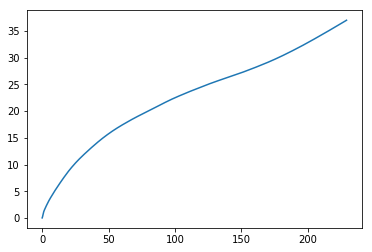

In [74]:
plt.figure()
plt.plot(Pose[:,0],Pose[:,1])

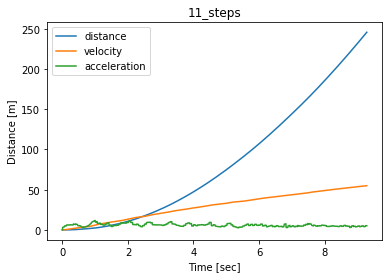

In [75]:
plt.figure()
plt.plot(acc_1['time'],dist)
plt.plot(acc_1['time'],Velocity_size)
plt.plot(acc_1['time'],Acceleration_size)
plt.ylabel('Distance [m]')
plt.xlabel('Time [sec]')
plt.title('11_steps')
plt.legend(['distance','velocity','acceleration'])
plt.savefig('11_steps')